In [1]:
import numpy as np
import joblib

from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
def average(all_x, all_y):
    ux = np.unique(np.concatenate(all_x))
    uy = np.zeros_like(ux)
    n = len(all_x)
    for x, y in zip(all_x, all_y):
        a = np.interp(ux, x, y)
        uy += a
    uy /= n
    return ux, uy

In [3]:
magnification_factor = '0X'

In [4]:
# Parameters
magnification_factor = "100X"


In [5]:
self_path = os.getcwd()
os.chdir('../../Probas')

In [6]:
paths = glob.glob('*_' + magnification_factor + '_*probas.joblib')
paths

['vgg_100X_probas.joblib',
 'vgginnet_100X_3_probas.joblib',
 'vgginnet_100X_4_probas.joblib',
 'vgginnet-ft_100X_5_probas.joblib',
 'vgginnet-ft_100X_3_probas.joblib',
 'vgginnet_100X_5_probas.joblib',
 'vgginnet_100X_2_probas.joblib',
 'vgginnet-ft_100X_4_probas.joblib',
 'vgginnet_100X_1_probas.joblib',
 'inception_100X_probas.joblib',
 'resnet_100X_probas.joblib',
 'vgginnet-ft_100X_1_probas.joblib',
 'vgginnet-ft_100X_2_probas.joblib']

In [7]:
def clean(name):
    name = name.replace('vgginnet', 'VGGIN-Net')
    name = name.replace('vgg', 'VGG16')
    name = name.replace('inception', 'GoogLeNet')
    name = name.replace('resnet', 'ResNet50')
    name = name.replace('-ft', '_with Fine Tuning')
    name = name.replace('_', ' ')

    name = name.replace(" " + magnification_factor + " ", " ")
    
    name = name.replace(' probas.joblib', '')
    return name

In [8]:
probas = {clean(path): joblib.load(path)['y_probas'] for path in paths}
list(probas.keys())

['VGG16',
 'VGGIN-Net 3',
 'VGGIN-Net 4',
 'VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net with Fine Tuning 3',
 'VGGIN-Net 5',
 'VGGIN-Net 2',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net 1',
 'GoogLeNet',
 'ResNet50',
 'VGGIN-Net with Fine Tuning 1',
 'VGGIN-Net with Fine Tuning 2']

In [9]:
labels = {clean(path): joblib.load(path)['y_test'] for path in paths}
labels = {key: np.argmax(labels[key], axis=-1) for key in labels}
list(labels.keys())

['VGG16',
 'VGGIN-Net 3',
 'VGGIN-Net 4',
 'VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net with Fine Tuning 3',
 'VGGIN-Net 5',
 'VGGIN-Net 2',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net 1',
 'GoogLeNet',
 'ResNet50',
 'VGGIN-Net with Fine Tuning 1',
 'VGGIN-Net with Fine Tuning 2']

In [10]:
n_classes = 2
def process(y_test, y_probas):
    y_test_oh = np.eye(n_classes)[np.int32(y_test)]
    fpr, tpr = [], []
    
    for index in range(n_classes):
        fp, tp, _ = roc_curve(y_test_oh[:, index], y_probas[:, index])
        fpr.append(fp)
        tpr.append(tp)

    f, t = average(fpr, tpr)
    return f, t

In [11]:
sns.set()
sns.set_style('whitegrid')

In [12]:
rocs = {key: process(labels[key], probas[key]) for key in probas.keys()}
rocs

{'VGG16': (array([0.        , 0.00248756, 0.00497512, 0.00609756, 0.00746269,
         0.00995025, 0.01219512, 0.01492537, 0.01741294, 0.01829268,
         0.0199005 , 0.02439024, 0.03233831, 0.03482587, 0.03658537,
         0.03731343, 0.039801  , 0.04228856, 0.04268293, 0.04726368,
         0.04878049, 0.04975124, 0.05223881, 0.05472637, 0.05487805,
         0.05970149, 0.06097561, 0.06467662, 0.06965174, 0.0721393 ,
         0.07317073, 0.07926829, 0.08536585, 0.08955224, 0.09146341,
         0.10945274, 0.1097561 , 0.1119403 , 0.11691542, 0.12195122,
         0.12804878, 0.13930348, 0.1402439 , 0.14179104, 0.14634146,
         0.14676617, 0.14925373, 0.15243902, 0.15920398, 0.17682927,
         0.18902439, 0.2195122 , 0.25      , 0.26219512, 0.27363184,
         0.27860697, 0.29268293, 0.32338308, 0.32835821, 0.34079602,
         0.38414634, 0.42288557, 0.4278607 , 0.43902439, 0.45731707,
         0.46517413, 0.48170732, 0.55721393, 0.56218905, 0.64676617,
         0.65174129, 0.81

In [13]:
single_fold = [
    'VGG16',
    'GoogLeNet',
    'ResNet50']

multi_fold = [
    'VGGIN-Net',
    'VGGIN-Net with Fine Tuning']

order = single_fold + multi_fold

In [14]:
curves = {}

for ord in multi_fold:
    fs, ts = [], []
    auc_vals = []
    for i in range(1, 5 + 1):
        name = ord + ' %d' % i
        f, t = rocs[name]
        
        auc_vals.append(auc(f, t))
        fs.append(f)
        ts.append(t)

    curves[ord] = {
        'curve': average(fs, ts),
        'auc_mean': np.mean(auc_vals),
        'auc_std': np.std(auc_vals)
    }

for ord in single_fold:
    f, t = rocs[ord]
    curves[ord] = {
        'curve': (f, t),
        'auc': auc(f, t)
    }

In [15]:
curves

{'VGGIN-Net': {'curve': (array([0.        , 0.00497512, 0.00746269, 0.01219512, 0.01243781,
          0.01492537, 0.01741294, 0.01829268, 0.0199005 , 0.02238806,
          0.02439024, 0.02985075, 0.0304878 , 0.03233831, 0.03658537,
          0.04228856, 0.04268293, 0.04726368, 0.04878049, 0.04975124,
          0.05223881, 0.05472637, 0.05487805, 0.05721393, 0.06097561,
          0.06218905, 0.06467662, 0.06707317, 0.06716418, 0.06965174,
          0.07317073, 0.07926829, 0.08536585, 0.08706468, 0.08955224,
          0.0920398 , 0.09452736, 0.09756098, 0.10199005, 0.10365854,
          0.10696517, 0.1097561 , 0.1119403 , 0.11442786, 0.12935323,
          0.1318408 , 0.13414634, 0.13432836, 0.13930348, 0.1402439 ,
          0.14634146, 0.14925373, 0.15243902, 0.15422886, 0.16463415,
          0.17164179, 0.17682927, 0.17910448, 0.18905473, 0.19402985,
          0.19900498, 0.2039801 , 0.20731707, 0.21144279, 0.21641791,
          0.21890547, 0.2195122 , 0.2238806 , 0.22885572, 0.23134328

In [16]:
os.chdir(self_path)
os.getcwd()

'/home/manisha.saini/vggin-net-github/utils/ROC'

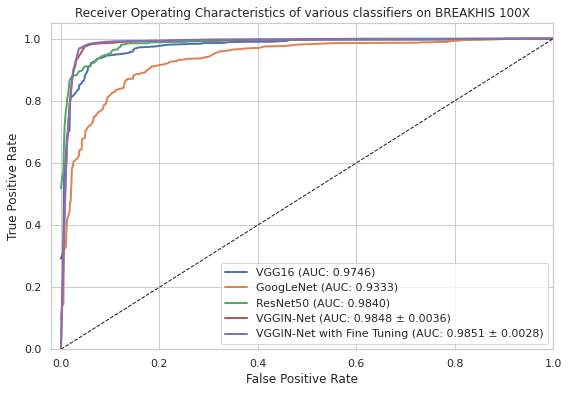

In [17]:
plt.figure(figsize=(9, 6))

lines = []
legends = []

for key in order:
    f, t = curves[key]['curve']
    line, = plt.plot(f, t, lw=2.)
    lines.append(line)

    if 'auc' in curves[key]:
        legends.append('%s (AUC: %0.4f)' % (key, curves[key]['auc']))
    else:
        legends.append('%s (AUC: %0.4f ± %0.4f)' % (key,
                                                    curves[key]['auc_mean'],
                                                    curves[key]['auc_std']))
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(lines, legends)
plt.title('Receiver Operating Characteristics of various classifiers on BREAKHIS ' + magnification_factor)
plt.savefig('ROC' + magnification_factor + '.pdf')
plt.show()